# Let's talk about machine learning


The phrase "machine learning" refers to any one of a number of methods for approximating a solution to a problem for which we don't have an analytical solution (an algorithmic solution) through examining data. The basic taxonomy of machine learning approaches is depicted below (from a SAS blog, see embedded link):

![ML algorithms](https://blogs.sas.com/content/subconsciousmusings/files/2017/04/machine-learning-cheet-sheet-2.png)

However, note that one can "mimic" supervised learning with minimal labeling via self-supervised learning or semi-supervised learning. Also note that this diagram does not include a third major class of ML algorithm, reinforcement learning.

When we talk about machine learning, we talk about:
* *fitting* (or *training*) a *prediction function*, or *model*, to
* *training* data, experimenting with various
* *hyperparameters* related to the *model architecture* using held-out
* *development* data, so that the resulting model generalizes well, making good *predictions* on held-out
* *test* (or *evaluation*) data

The goal of unsupervised learning is to uncover latent structure or patterns in the data. The goal of supervised learning is to learn to match the labels (or answers, or ground truth, or dependent variable) in the data. We will spend the rest of the semester looking at three supervised ML algorithms:
* k-nearest neighbors
* naive Bayes
* radial basis function networks (a type of neural network)

If you want to investigate ML further, here is a great python library for ML:
* scikit-learn (sklearn): https://scikit-learn.org/stable/index.html
(you will use sklearn for Lab 6)

And here are two specifically for DL:
* tensorflow: https://www.tensorflow.org/
* pytorch: https://pytorch.org/

Sklearn uses a pattern; for each ML algorithm, there is a fit function (for training), a predict function (for inference or testing), and a score function (for evaluation).

We evaluate models / prediction functions using [any number of metrics](https://scikit-learn.org/stable/modules/model_evaluation.html). A commonly used one for supervised machine learning is:
* accuracy - what percent of the data points were classified correctly?

Of course, accuracy is just one number. To get a clearer understanding, we can construct a
* confusion matrix,
which has the classes (the labels) along rows and columns, and in each cell indicates the number of data points classified as *row* that are truly in class *column*. 

We saw an early version of this on day 22, when we looked at which classes of digit kmeans was confusing with which other class of digit.

# K-nearest neighbors

K-nearest neighbors (KNNs) is a very very simple supervised ML algorithm.
* fit - it just stores all the training data!
* predict - it finds the data points in the training data that are closest to the data point to be classified, and takes a majority vote of their labels

Let's implement k-nearest neighbors!

In [1]:
import numpy as np
import utilityfunctions as uf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

class kNN:
    def __init__(self):
        self.model = None
        self.labels = None
        self.k = 2
        
    # Let's define fit for kNN
    def fit(self, data, labels, k, distanceMetric=None):
        self.model = data
        self.labels = labels
        assert len(self.model) == len(self.labels)
        self.k = k
        if distanceMetric != None:
            self.distanceMetric = distanceMetric
        else:
        # Let's define a distance metric; which one is this??
            self.distanceMetric = lambda a, b: np.sqrt(np.dot((a-b).T, a-b))

    # Let's define predict for kNN
    def predictOne(self, element):
        neighborsByDistance = np.argpartition([self.distanceMetric(element, datapoint) for datapoint in self.model], self.k)
        # print([(x, self.distanceMetric(element, x)) for x in self.model[neighborsByDistance]])
        neighborLabels = [self.labels[neighborsByDistance[x]] for x in range(self.k)]
        # print(neighborLabels)
        vals, counts = np.unique(neighborLabels, return_counts=True)
        # print(vals, counts)
        return vals[np.argwhere(counts == np.max(counts))][0,0]
                                                                                                
    def predict(self, elements):
        return np.array([self.predictOne(element) for element in elements])
    
    def accuracy(self, y, yhat):
        diffs = y == yhat
        vals, counts = np.unique(diffs, return_counts=True)
        return counts[np.where(vals == True)] / (np.sum(counts))
    
    def confusionMatrix(self, y, yhat):
        "Thanks to https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python"
        labelMappings = dict(zip(np.unique(self.labels), range(len(np.unique(self.labels))))) 
        assert len(y) == len(yhat)
        result = np.zeros((len(labelMappings), len(labelMappings)))
        for i in range(len(y)):
            result[labelMappings[y[i]]][labelMappings[yhat[i]]] += 1
        return result

    def score(self, elements, labels):
        predictedLabels = self.predict(elements)
        return self.accuracy(labels, predictedLabels), self.confusionMatrix(labels, predictedLabels)

## Let's try it on some data!

This data is from https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset. Take a look at it!

What is the format of the data file?

How many features are there and what are their types?

What index feature will be our dependent variable, our label?

In [2]:
# Load the data

def convertLabel(label):
    labels = {'SEKER': 0, 'BARBUNYA': 1, 'BOMBAY': 2, 'CALI': 3, 'HOROZ': 4, 'SIRA': 5, 'DERMASON': 6}
    return float(labels[str(label)])

data = np.array(np.genfromtxt('data/Dry_Bean_Dataset.arff', delimiter=',', converters={16: convertLabel}, skip_header=25, dtype=float, encoding='utf-8'))  

## Let's look at our data! 

What do we notice? 

What should we do to fix this?

((13611, 17), dtype('float64'))
             0             1            2            3         4         5   \
0  2.546160e+05   1985.370000   738.860153   460.198497  2.430306  0.911423   
1  2.042000e+04    524.736000   183.601165   122.512653  1.024868  0.218951   
2  5.304828e+04    855.283459   320.141867   202.270714  1.583242  0.750895   
3  8.598394e+08  45916.700018  7342.953981  2022.160532  0.060846  0.008464   

             6            7         8         9         10        11  \
0  2.632610e+05   569.374358  0.866195  0.994677  0.990685  0.987303   
1  2.068400e+04   161.243764  0.555315  0.919246  0.489618  0.640577   
2  5.376820e+04   253.064220  0.749733  0.987143  0.873282  0.799864   
3  8.864805e+08  3501.674262  0.002409  0.000022  0.003542  0.003808   

         12            13        14        15        16  
0  0.010451  3.664972e-03  0.974767  0.999733  6.000000  
1  0.002778  5.641690e-04  0.410339  0.947687  0.000000  
2  0.006564  1.715947e-03  0.643590  

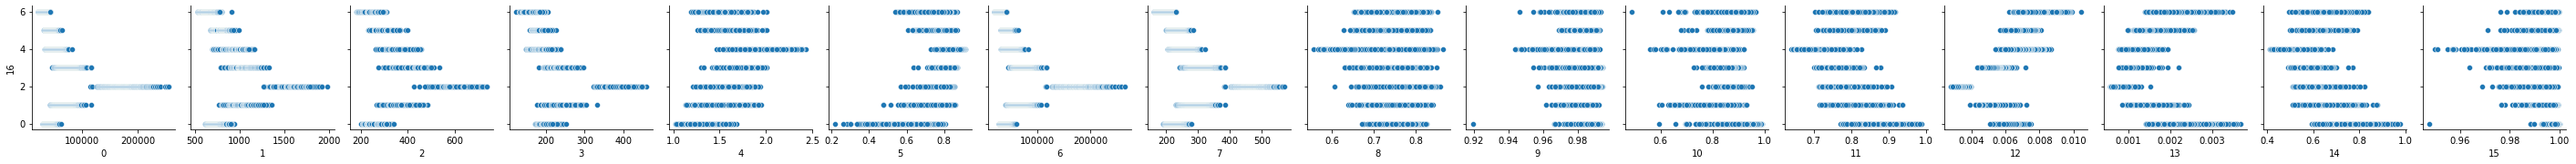

Label distribution:
(array([0., 1., 2., 3., 4., 5., 6.]), array([2027, 1322,  522, 1630, 1928, 2636, 3546], dtype=int64))


In [3]:
print(uf.getShapeType(data))
print(uf.getSummaryStatistics(data))

df = pd.DataFrame(data)
seaborn.pairplot(df, y_vars = 16, x_vars=range(0,16))

plt.show()

# Let's take a special look at the labels
print("Label distribution:")
print(np.unique(data[:, -1], return_counts=True))

## Let's split the data into train, dev and test!

What do we notice?

In [4]:
# Split into train, dev, test
train, dev, test = np.split(data, [int(.8 * len(data)), int(.9 * len(data))])
print(train.shape, dev.shape, test.shape)

# Let's make sure our labels are in each split
print(np.unique(train[:, -1], return_counts=True))
print(np.unique(dev[:, -1], return_counts=True))
print(np.unique(test[:, -1], return_counts=True))

(10888, 17) (1361, 17) (1362, 17)
(array([0., 1., 2., 3., 4., 5., 6.]), array([2027, 1322,  522, 1630, 1928, 2636,  823], dtype=int64))
(array([6.]), array([1361], dtype=int64))
(array([6.]), array([1362], dtype=int64))


### Not good! 

Let's do stratified sampling; this is when we sample by category.

This is why it's so important to __always look at your data__.


In [5]:
# Split the data into subarrays, where each subarray has only data points with a single label
byGroups = np.split(data, np.where(np.diff(data[:,-1]))[0]+1)
print(len(byGroups))
print([len(x) for x in byGroups])

train = []
dev = []
test = []
for group in byGroups:
    gtrain, gdev, gtest = np.split(group, [int(.8 * len(group)), int(.9 * len(group))])
    train.append(gtrain)
    dev.append(gdev)
    test.append(gtest)

train = np.vstack(train)
dev = np.vstack(dev)
test = np.vstack(test)

print(train.shape, dev.shape, test.shape)

# Let's make sure our labels are in each split
print(np.unique(train[:, -1], return_counts=True))
print(np.unique(dev[:, -1], return_counts=True))
print(np.unique(test[:, -1], return_counts=True))

# You could do a random shuffle on train at this point, but for kNN the order of presentation of data points doesn't matter for training.
np.random.shuffle(train)
np.random.shuffle(dev)
np.random.shuffle(test)

7
[2027, 1322, 522, 1630, 1928, 2636, 3546]
(10885, 17) (1362, 17) (1364, 17)
(array([0., 1., 2., 3., 4., 5., 6.]), array([1621, 1057,  417, 1304, 1542, 2108, 2836], dtype=int64))
(array([0., 1., 2., 3., 4., 5., 6.]), array([203, 132,  52, 163, 193, 264, 355], dtype=int64))
(array([0., 1., 2., 3., 4., 5., 6.]), array([203, 133,  53, 163, 193, 264, 355], dtype=int64))


### Much better!

## Let's train some models!

In [6]:
%%time

# Train a model

x = train[:, :-1]
y = train[:, -1]

# We have to normalize the data because when we looked at it we saw the ranges varied widely across features
x = uf.preprocess(x, zscore=True)
# Sanity check
print(uf.getSummaryStatistics(x))

mykNN = kNN()
mykNN.fit(x, y, 2)

             0             1             2             3             4   \
0  5.140961e+00  4.493908e+00  4.381214e+00  5.031225e+00  3.445731e+00   
1 -1.100144e+00 -1.510000e+00 -1.561807e+00 -1.744752e+00 -2.222067e+00   
2  9.269368e-17 -4.060244e-16  4.869682e-16  4.256076e-16 -7.245773e-17   
3  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

             5             6             7             8             9   \
0  1.741636e+00  5.193194e+00  4.339136e+00  2.377941e+00  1.643072e+00   
1 -5.622044e+00 -1.099090e+00 -1.515329e+00 -4.007552e+00 -1.470073e+01   
2 -8.316320e-16 -5.222179e-17  5.091625e-16  2.364342e-15  1.374216e-14   
3  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

             10            11            12            13            14  \
0  1.945369e+00  2.974497e+00  3.328080e+00  3.124954e+00  3.272253e+00   
1 -6.483493e+00 -2.587827e+00 -3.196842e+00 -1.897426e+00 -2.361164e+00   
2  2.502729e-15  3.5106

In [7]:
%%time

# Test the model on dev

xd = dev[:, :-1]
yd = dev[:, -1]

# We have to normalize the data because when we looked at it we saw the ranges varied widely across features
xd = uf.preprocess(xd, zscore=True)
# Sanity check
print(uf.getSummaryStatistics(xd))

mykNN.score(xd, yd)

             0             1             2             3             4   \
0  4.466248e+00  3.935933e+00  4.111222e+00  4.764844e+00  2.943024e+00   
1 -7.394732e-01 -1.014493e+00 -1.115949e+00 -1.137210e+00 -2.125269e+00   
2  2.608454e-18  2.882341e-16  7.564515e-17 -3.599666e-16 -2.191101e-16   
3  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

             5             6             7             8             9   \
0  1.679733e+00  4.581041e+00  3.965267e+00  1.957526e+00  1.376101e+00   
1 -4.301971e+00 -7.428488e-01 -9.086897e-01 -3.357500e+00 -7.789139e+00   
2  1.927647e-15 -5.086484e-17  2.412819e-17 -1.218148e-15  7.115861e-15   
3  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

             10            11            12            13            14  \
0  1.974144e+00  2.741409e+00  1.761814e+00  2.609821e+00  2.978344e+00   
1 -3.921681e+00 -2.336566e+00 -3.321505e+00 -1.939650e+00 -2.164545e+00   
2  4.773470e-16 -7.1210

(array([0.95374449]),
 array([[190.,   1.,   0.,   0.,   0.,   5.,   7.],
        [  0., 129.,   0.,   3.,   0.,   0.,   0.],
        [  0.,   0.,  52.,   0.,   0.,   0.,   0.],
        [  0.,  11.,   0., 152.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   5., 187.,   1.,   0.],
        [  6.,   1.,   0.,   0.,  12., 245.,   0.],
        [  8.,   0.,   0.,   0.,   2.,   1., 344.]]))

[(2, array([0.95374449])), (3, array([0.97283407])), (4, array([0.96989721])), (5, array([0.9743025])), (6, array([0.97209985]))]


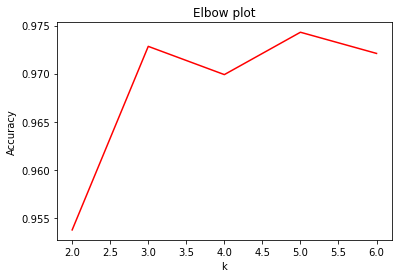

Wall time: 6min 24s


In [8]:
%%time

# Do a little "hyperparameter tuning": train models for k = 2 to 6, then pick the best one using dev

accuracies = []
for k in range(2, 7):
    mykNN.fit(x, y, k)
    accuracy, confusionMatrix = mykNN.score(xd, yd)
    accuracies.append((k, accuracy))
    
print(accuracies)

# plotting
plt.title("Elbow plot")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.plot([x[0] for x in accuracies], [x[1] for x in accuracies], color ="red")
plt.show()

## Let's evaluate!

In [9]:
%%time

# Test the best model
mykNN.fit(x, y, 5)

xt = test[:, :-1]
yt = test[:, -1]

# We have to normalize the data because when we looked at it we saw the ranges varied widely across features
xt = uf.preprocess(xt, zscore=True)
# Sanity check
print(uf.getSummaryStatistics(xt))

mykNN.score(xt, yt)

             0             1             2             3             4   \
0  5.237689e+00  4.343064e+00  4.019159e+00  4.857325e+00  3.001811e+00   
1 -7.513767e-01 -1.019131e+00 -1.159558e+00 -1.128447e+00 -2.279864e+00   
2  1.354407e-16 -1.136920e-15  9.767358e-17 -6.882732e-16 -3.203693e-16   
3  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

             5             6             7             8             9   \
0  1.706749e+00  5.358430e+00  4.437939e+00  1.870264e+00  1.343207e+00   
1 -4.811908e+00 -7.544479e-01 -9.288200e-01 -3.424484e+00 -8.349222e+00   
2 -1.208548e-15 -1.693009e-17 -1.159060e-16  6.537618e-16 -8.689042e-15   
3  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

             10            11            12            13            14  \
0  1.939730e+00  2.976235e+00  1.727294e+00  2.854561e+00  3.249504e+00   
1 -4.187007e+00 -2.367160e+00 -3.300405e+00 -1.888423e+00 -2.191930e+00   
2  1.999053e-15 -1.5575

(array([0.9516129]),
 array([[174.,   0.,   0.,   0.,   0.,  15.,  14.],
        [  0., 128.,   0.,   5.,   0.,   0.,   0.],
        [  0.,   0.,  53.,   0.,   0.,   0.,   0.],
        [  0.,   6.,   0., 157.,   0.,   0.,   0.],
        [  0.,   1.,   0.,   3., 188.,   1.,   0.],
        [  2.,   1.,   0.,   0.,  10., 250.,   1.],
        [  7.,   0.,   0.,   0.,   0.,   0., 348.]]))

# Questions:
What are some of the hyperparameters related to kNN?

How would you pick good values for them?

kNN is expensive in terms of computational cost and memory. You can address each of these costs using methods *we already know*.
* to make it faster, what can you do?
* To make it less memory intensive, what can you do?